## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Aug 21 23:27:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40-2B       On   | 00000000:02:01.0  On |                  N/A |
| N/A   N/A    P0    N/A /  N/A |   1110MiB /  1889MiB |      2%   Prohibited |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /mobileye/RPT/users/kfirs/kfir_project/MSC_Project/notebook


## Install Segment Anything Model (SAM) and other dependencies

In [3]:
# !pip install ultralytics

In [4]:
# !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

## Load Model

In [5]:
import torch
import tkinter as tk
from tkinter import filedialog
from IPython.display import display
import ipywidgets as widgets
import open3d as o3d
from open3d.cuda.pybind.geometry import TriangleMesh
import numpy as np
import cv2


# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
MODEL_TYPE = "vit_h"


# Function to open file dialog and get the file path
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("OBJ files", "*.obj")])
    path_widget.value = file_path

# Create a button widget
button_widget = widgets.Button(description="Select .obj file")

# Create a text widget to display the file path
path_widget = widgets.Text(
    value='',
    placeholder='File path will appear here',
    description='File Path:',
    disabled=False
)


def load_mesh(filename):
    """ Load a mesh from an OBJ file and return its vertices and normals. """
    mesh: TriangleMesh = o3d.io.read_triangle_mesh(filename)
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)  # Assume normals are already normalized
    return vertices, normals

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
from ultralytics import SAM

# Load a model
model = SAM("sam2_l.pt")

# Display model information (optional)
model.info()


Model summary: 854 layers, 224,430,130 parameters, 224,430,130 gradients


(854, 224430130, 224430130, 0.0)

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

# Define function to create ortho image

In [7]:
# Bind the function to the button click event
button_widget.on_click(lambda b: select_file())

# Display the widgets
display(button_widget)
display(path_widget)


Button(description='Select .obj file', style=ButtonStyle())

Text(value='', description='File Path:', placeholder='File path will appear here')

In [8]:
from orthograohic_image import capture_textured_image_and_depth_from_obj
obj_path = path_widget.value
image_path, output_depth_path, camera_params_path = capture_textured_image_and_depth_from_obj(obj_path)
print(image_path)
print(obj_path)

./images/S01_ortho.png
/mobileye/RPT/users/kfirs/kfir_project/MSC_Project/models/valid_models/S01/S01.obj


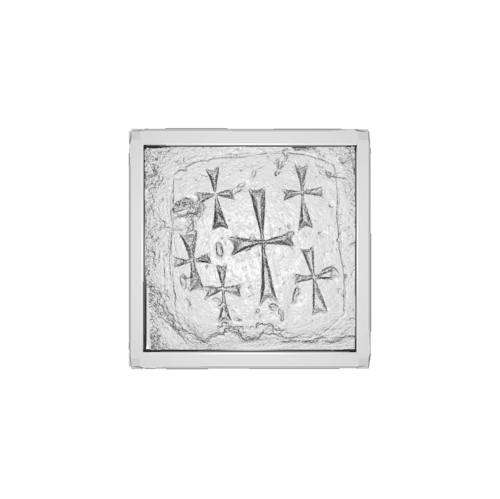

In [9]:
import matplotlib.pyplot as plt

# Load the orthoimage
ortho_image = cv2.imread(image_path)

# Display the orthoimage
plt.imshow(ortho_image)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

### Draw Box



**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [10]:
from numpy import ndarray
from typing import Union
# helper function that loads an image before adding it to the widget

import base64

def encode_image(input: Union[str,ndarray]):
    if isinstance(input, str):     
        with open(input, "rb") as image:
            image_bytes = image.read()
    else:
        image_bytes = cv2.imencode('.jpg', input)[1]
        
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [11]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget( classes=['cross'])
widget.image = encode_image(image_path)

# Set resolution of the image
widget.width = ortho_image.shape[1]
widget.height = ortho_image.shape[0]


widget

BBoxWidget(classes=['cross'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [15]:
import numpy as np

box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

boxes = []
for box in widget.bboxes:
    boxes.append(np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']]))
    

# Print the box coordinates
boxes

[array([581, 321, 674, 472]),
 array([468, 379, 614, 631]),
 array([396, 333, 484, 472]),
 array([346, 472, 430, 602]),
 array([607, 501, 697, 652]),
 array([407, 542, 498, 665])]

In [16]:
import cv2
import numpy as np

# all_masks = []
# all_masks_results=[]


# Predict masks for each box
# for box in boxes:
# for box in boxes:
all_masks = model(image_path, bboxes=boxes)
    # for result in results:
    #     # result.show()  # This will display each result individually
    #     mask = results[0][0].numpy().masks.data.squeeze()
    #     all_masks.append(mask)
    #     all_masks_results.append( results[0][0])
    


image 1/1 /mobileye/RPT/users/kfirs/kfir_project/MSC_Project/notebook/images/S01_ortho.png: 1024x1024 6747.9ms
Speed: 14.3ms preprocess, 6747.9ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)


In [17]:
for mask in all_masks:
    mask.show()

In [18]:
mask_colors = np.random.randint(100, 255, (len(all_masks[0]), 3))
all_masks = all_masks[0].masks.data

# Save the masks and mask colors the same folder as the image with a prefix
masks_path = image_path.replace(".png", "_masks.npy")
colors_path = image_path.replace(".png", "_colors.npy")

np.save(masks_path, all_masks)
np.save(colors_path, mask_colors)

# Display the paths to the saved masks and colors
masks_path, colors_path

('./images/S01_ortho_masks.npy', './images/S01_ortho_colors.npy')

In [19]:
from project_masks_to_3d import project_masks_to_mesh
# Apply the masks to the mesh
masked_point_cloud = project_masks_to_mesh(obj_path, masks_path, colors_path, camera_params_path, output_depth_path)

Processing masks: 100%|██████████| 6/6 [00:00<00:00, 14.63it/s]
Assigning colors to mesh vertices: 689698it [00:08, 77097.24it/s]


[Open3D WARNING] Write OBJ can not include triangle normals.


In [ ]:
from extract_and_save_masked_areas import extract_and_save_masked_areas

output_dir = os.path.join(os.path.dirname(obj_path), "masked_areas")

### Extract the 3D masked mesh from the masked point cloud
extract_and_save_masked_areas(masked_point_cloud, output_dir)

In [ ]:
from extract_and_save_masked_areas import display_masked_areas

### Display the masked areas
display_masked_areas(output_dir)